## Setup Environment

In [2]:
# Install specific libraries
! pip install transformers
! pip install pycaret
! pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 93.5 MB/s eta 0

In [3]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import DistilBertModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [4]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set Working Directory - if working on Google Drive
%cd /content/drive/MyDrive/Misinformation/DataSet/train

# # Set Working Directory - if working on Local Machine
# import os
# os.chdir('/Users//replace_me')

/content/drive/MyDrive/Misinformation/DataSet/train


## Load Dataset

In [6]:
# Load Dataset
data = pd.read_csv('train.csv')

# See how the data looks like
print(data.shape)
data.head()

(232003, 2)


,text,label
0,The court granted by a 5-4 vote a request made...,real
1,""" Pennsylvania was a crucial swing state in th...",real
2,The company today is rolling out an update to ...,fake
3,"When it comes to trade policy, Hillary Clinton...",real
4,S. stocks had their worst April start since 19...,real


In [7]:
# Randomly sample 20000 rows from your DataFrame
data = data.sample(n=20000, random_state=1)
# See how the data looks like
print(data.shape)
data.head()

(20000, 2)


,text,label
73051,"losed border hotline with South Korea, hours a...",fake
208822,Banco Popolare says: * will hold extraordinary...,real
85424,"We have to re-establish order in our country,""...",real
210998,"Bridgepoint Education Inc * On July 7, 2016, r...",real
77420,Policy insiders say the slowdown in private in...,real


In [8]:
# Target column is made of string values True/Fake, let's change it to numbers 0/1 (Fake=1)
data['binary'] = pd.get_dummies(data.label)['fake']

# Perform undersampling
rus = RandomUnderSampler(random_state=42)
data, data['binary'] = rus.fit_resample(data, data['binary'])


In [9]:
data.head()

,text,label,binary
0,While factory data from across the euro zone s...,real,0
1,"President Trump tweeted his opinion that ""the ...",real,0
2,The Trump administration moved on Wednesday to...,real,0
3,He noted that German fashion sales were down 1...,real,0
4,Canal Plus currently pays about $40 million a ...,real,0


([<matplotlib.patches.Wedge at 0x7bbcf85db850>,
 [Text(-1.2000000000000002, 1.469576158976824e-16, 'fake'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'real')],
 [Text(-0.7, 8.572527594031472e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

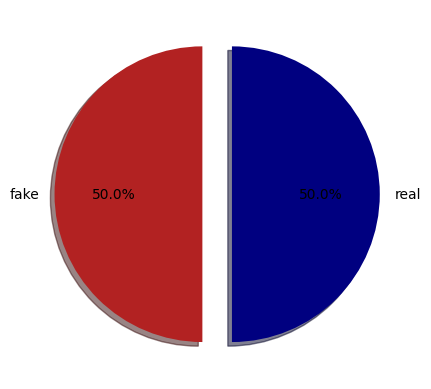

In [10]:
# Checking if our data is well balanced
label_size = [data['binary'].sum(),len(data['binary'])-data['binary'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['fake','real'],autopct='%1.1f%%')

## Train-test-split

In [11]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['binary'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['label'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)



## BERT Fine-tuning

### Load pretrained BERT Model

In [12]:
# Load BERT model and tokenizer via HuggingFace Transformers
from transformers import DistilBertModel, DistilBertTokenizerFast
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


### Prepare Input Data

In [13]:
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)




# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [14]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 16                                                   #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

### Freeze Layers

In [15]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

### Define Model Architecture

In [16]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function

    def forward(self, sent_id, mask):           # define the forward pass
      output = self.bert(sent_id, attention_mask=mask)
      cls_hs = output.last_hidden_state[:, 0]   # get the hidden state of the first token of the last layer
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x




model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 2

### Define Train & Evaluate Function

In [17]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

### Model training

In [18]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    509.
  Batch   100  of    509.
  Batch   150  of    509.
  Batch   200  of    509.
  Batch   250  of    509.
  Batch   300  of    509.
  Batch   350  of    509.
  Batch   400  of    509.
  Batch   450  of    509.
  Batch   500  of    509.

Evaluating...
  Batch    50  of    110.
  Batch   100  of    110.

Training Loss: 0.657
Validation Loss: 0.614

 Epoch 2 / 2
  Batch    50  of    509.
  Batch   100  of    509.
  Batch   150  of    509.
  Batch   200  of    509.
  Batch   250  of    509.
  Batch   300  of    509.
  Batch   350  of    509.
  Batch   400  of    509.
  Batch   450  of    509.
  Batch   500  of    509.

Evaluating...
  Batch    50  of    110.
  Batch   100  of    110.

Training Loss: 0.585
Validation Loss: 0.543


### Model performance

In [22]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.82      0.69      0.75       873
           1       0.73      0.85      0.79       873

    accuracy                           0.77      1746
   macro avg       0.78      0.77      0.77      1746
weighted avg       0.78      0.77      0.77      1746

